# DenseNet

### Reference
1. [Paper]()

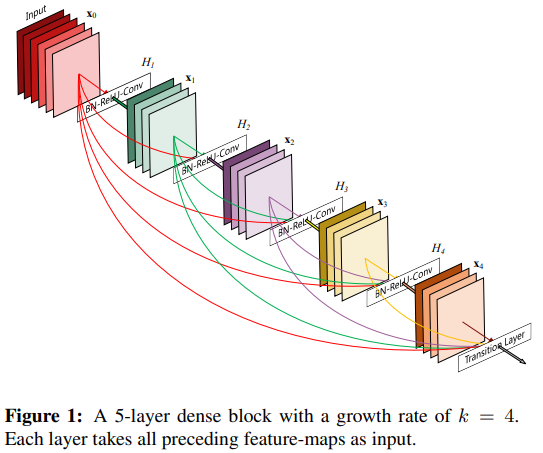

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import backend

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [99]:
y_train[0]

array([6], dtype=uint8)

In [5]:
x_train = x_train / 255.

In [97]:
class ModelConfig:
  epochs = 40
  batch_size = 64
  lr = 0.1
  dropout_rate = 0.2
  layer_init = initializers.HeNormal()
  loss = losses.SparseCategoricalCrossentropy()
  metric= metrics.Accuracy()
  optimizer = optimizers.SGD(learning_rate=lr)
  decay_rate = 1e-4
  decay = regularizers.L2(decay_rate)
  k = 12
  layers = [12, 12, 12]

In [71]:
class LRSchedule(callbacks.Callback):
  def __init__(self):
    self.epochs = None
    self.half = None
    self.seventy_five = None

  def on_train_begin(self, logs=None):
    self.epochs = self.params.get('epochs')
    self.half = int(self.epochs * 0.5)
    self.seventy_five = int(self.epochs * 0.75)
    if self.model.optimizer.learning_rate is None:
      backend.set_value(self.model.optimizer.learning_rate, 0.1)

  def on_the_epoch_end(self, epoch, logs=None):
    if epoch == self.half or epoch == self.seventy_five:
      curr_lr = backend.get_value(self.model.optimizer.learning_rate)
      updated_lr = float(curr_lr / 10)
      backend.set_value(self.model.optimizer.learning_rate, updated_lr)
      logs['curr_lr'] = updated_lr

In [49]:
def stem_cell(inputs, k=16, imagenet_dataset:bool=False):
  '''
  Args
    inputs      (tf.keras.layers.Input):
    k                             (int): growth rate
  Return
    tf.tensor
  '''
  if imagenet_dataset:
    init_kernel = (7, 7)
    init_stride = (2, 2)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
  else:
    init_kernel = (3, 3)
    init_stride = (1, 1)
  x = layers.Conv2D(filters=k, kernel_size=init_kernel,
                    strides=init_stride, padding='same',
                    kernel_initializer=ModelConfig.layer_init,
                    kernel_regularizer=ModelConfig.decay)(inputs)
  if imagenet_dataset:
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
  return x

In [16]:
def conv_layer(X, k, bottleneck:bool=False, dropout_rate:float=None):
  '''
  Args
    X           (tf.tensor) : input feature
    k                 (int) : growth rate
    bottleneck       (bool) : 
    dropout_rate    (float): dropout rate. If None, dropout layer will not be applied.
  Return
    tf.tensor
  '''
  assert 0 < dropout_rate < 1
  
  x = layers.BatchNormalization()(X)
  x = layers.ReLU()(x)
  if bottleneck:
    x = layers.Conv2D(filters=4*k, kernel_size=(1, 1),
                      strides=(1, 1), padding='same',
                      kernel_initializer=ModelConfig.layer_init,
                      kernel_regularizer=ModelConfig.decay)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
  x = layers.Conv2D(filters=k, kernel_size=(3, 3),
                    strides=(1, 1), padding='same',
                    kernel_initializer=ModelConfig.layer_init,
                    kernel_regularizer=ModelConfig.decay)(x)
  if dropout_rate:
    x = layers.Dropout(rate=dropout_rate)(x)
  return x

In [85]:
def dense_block(X, k, num_layer, dropout_rate):
  x = X
  for i in range(num_layer):
    ck = conv_layer(x, k=k, dropout_rate=dropout_rate)
    x = layers.Concatenate()([x, ck])
  return x

In [86]:
def transition_layer(X, k=ModelConfig.k, theta:float=1):
  '''
  Args
    X         (tf.tensor) : input feature
    k               (int) : growth rate
    theta         (float) : compression rate. It make compress input channel 
                            by theta * channel. If theta = 1, no compression.
  Return
    tf.tensor
  '''
  assert 0 < theta <= 1
  x = layers.BatchNormalization()(X)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=theta * k, kernel_size=(1, 1),
                    strides=(1, 1), padding='same',
                    kernel_initializer=ModelConfig.layer_init,
                    kernel_regularizer=ModelConfig.decay)(X)
  x = layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)
  return x

In [77]:
def head(X):
  x = layers.GlobalAveragePooling2D()(X)
  x = layers.Dense(10, activation='softmax')(x)
  return x

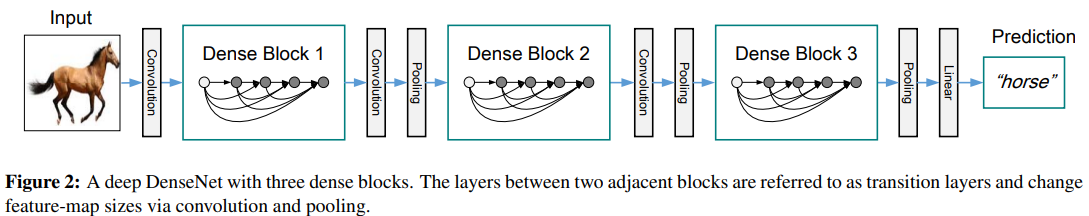

In [92]:
def densenet_40(inputs, layer, k, dropout_rate):
  x = stem_cell(inputs)
  for n_layer in layer[:-1]:
    x = dense_block(x, k=k, num_layer=n_layer, dropout_rate=dropout_rate)
    x = transition_layer(x, k=k)
  x = dense_block(x, k=k, num_layer=layer[-1], dropout_rate=dropout_rate)
  x = head(x)
  print(f'netework head shape: {x.shape}')
  return x

In [93]:
def create_model(inputs, layer=ModelConfig.layers, k=ModelConfig.k, dropout=ModelConfig.dropout_rate):
  if inputs is None:
    inputs = layers.Input(shape=(32, 32, 3), batch_size=ModelConfig.batch_size)
  x = densenet_40(inputs, layer=layer, k=k, dropout_rate=dropout)
  model = models.Model(inputs=inputs, outputs=x)
  return model

In [100]:
def train(model,
          optimizer=ModelConfig.optimizer,
          epochs=ModelConfig.epochs,
          batch_size=ModelConfig.batch_size,
          loss='sparse_categorical_crossentropy',
          metric='accuracy'):
  model.compile(optimizer=optimizer, loss=loss, metrics=metric)
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[LRSchedule()])

In [95]:
model = create_model(inputs=None)
model.summary()

GAP layer: (64, 156)
Dense layer: (64, 10)
netework head shape: (64, 10)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(64, 32, 32, 3)]    0           []                               
                                                                                                  
 conv2d_120 (Conv2D)            (64, 32, 32, 16)     448         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_114 (Batch  (64, 32, 32, 16)    64          ['conv2d_120[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_114 (ReLU)  

In [101]:
train(model)

Epoch 1/40
625/625 [==============================] - 62s 87ms/step - loss: 1.7678 - accuracy: 0.3790 - val_loss: 1.7957 - val_accuracy: 0.4144
Epoch 2/40
625/625 [==============================] - 56s 90ms/step - loss: 1.3868 - accuracy: 0.5261 - val_loss: 1.4363 - val_accuracy: 0.5217
Epoch 3/40
625/625 [==============================] - 54s 86ms/step - loss: 1.2299 - accuracy: 0.5882 - val_loss: 2.2448 - val_accuracy: 0.4348
Epoch 4/40
625/625 [==============================] - 56s 89ms/step - loss: 1.1321 - accuracy: 0.6247 - val_loss: 1.4072 - val_accuracy: 0.5334
Epoch 5/40
625/625 [==============================] - 56s 89ms/step - loss: 1.0652 - accuracy: 0.6523 - val_loss: 1.3721 - val_accuracy: 0.5971
Epoch 6/40
625/625 [==============================] - 54s 86ms/step - loss: 1.0024 - accuracy: 0.6733 - val_loss: 1.3526 - val_accuracy: 0.5887
Epoch 7/40
625/625 [==============================] - 56s 89ms/step - loss: 0.9575 - accuracy: 0.6955 - val_loss: 1.6351 - val_accuracy:

## Model's good but what I don't get it
1. From the study, $\{L=40,k=12\}$ model has 1M parameter, however what I have implemented here has 0.3M.
2. I think I misunderstood growth rate.